In [18]:
import numpy as np
from imageio import imread
from skimage.transform import resize
from keras.applications.mobilenet_v2 import preprocess_input
from keras import Model
from keras.layers import Dense
from keras.optimizers import Adam,RMSprop,Adadelta,SGD
import os
from keras.applications.mobilenet_v2 import MobileNetV2
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import pandas as pd


In [44]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #virgülden sonra 3 basamak göster

In [3]:
data = np.empty((3000,96,96,3))
for i in range(1499):
  im = imread("/content/drive/MyDrive/Colab Notebooks/data/yes/y{:01d}.jpg".format(i+1))
  im = preprocess_input(im)
  im = resize(im,output_shape=(96,96,1))
  data[i] = im

for i in range(1499):
  im = imread("/content/drive/MyDrive/Colab Notebooks/data/no/no{:01d}.jpg".format(i+1))
  im = preprocess_input(im)
  im = resize(im,output_shape=(96,96,1))
  data[i+1500] = im

In [4]:
import numpy as np
labels = np.empty(3000,dtype = int)
labels[:1500] = 1
labels[1500:] = 0
labels.shape

(3000,)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, shuffle =True)


print(f"X_train: {len(X_train)}")
print(f"y_train: {len(y_train)}")

print(f"X_train shape: {X_train.shape}")

print(f"X_test: {len(X_test)}")
print(f"y_test: {len(y_test)}")

X_train: 2400
y_train: 2400
X_train shape: (2400, 96, 96, 3)
X_test: 600
y_test: 600


In [10]:
def define_model(hp):
  model = MobileNetV2(weights ="imagenet", include_top = False ,pooling='avg',input_shape=(96,96,3))
  predictions = Dense(2, activation = 'sigmoid')(model.output)
  head_model = Model(inputs = model.input, outputs = predictions)

  for layer in model.layers:
    layer.trainable = False

  optimizer = hp.Choice('optimizer',values=['Adam','SGD','Adadelta','RMSprop'])
  learning_rate=hp.Choice('learning_rate',values=[1e-3,1e-4])
  head_model.compile(optimizer= Adam(learning_rate),
                   loss= "sparse_categorical_crossentropy",
                   metrics=['accuracy']
                   )  

  return head_model

In [22]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1,mode="min",restore_best_weights=True)

In [7]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.1 MB/s eta 0:00:00


In [8]:
import keras_tuner
from keras_tuner.engine.hyperparameters import HyperParameters

In [11]:
tuner = keras_tuner.RandomSearch(
    define_model,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial = 1,
    directory = "klasör",
    project_name="deneme",
    overwrite = True
    )

In [12]:
tuner.search(X_train, y_train,epochs=50,validation_split = 0.2)

Trial 8 Complete [00h 00m 53s]
val_accuracy: 0.9791666865348816

Best val_accuracy So Far: 0.9791666865348816
Total elapsed time: 00h 09m 53s


In [13]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'optimizer': 'RMSprop', 'learning_rate': 0.001}


In [14]:
def built_model():
  base_model = MobileNetV2(weights ="imagenet", include_top = False ,pooling='avg',input_shape=(96,96,3))
  predictions = Dense(2, activation = 'sigmoid')(base_model.output)
  head_model = Model(inputs = base_model.input, outputs = predictions)

  for layer in base_model.layers:
    layer.trainable = False

  optimizer = RMSprop(learning_rate = 0.001)
  head_model.compile(optimizer= optimizer,
                   loss= "sparse_categorical_crossentropy",
                   metrics=['accuracy']
                   )  

  return head_model

In [15]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn= built_model,epochs =50 ,batch_size=64,verbose=2 )

<ipython-input-15-b14f3010d4d2>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn= built_model,epochs =50 ,batch_size=64,verbose=2 )


In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model,X_train,y_train,cv=3,scoring="accuracy")

Epoch 1/50
25/25 - 3s - loss: 0.5425 - accuracy: 0.7425 - 3s/epoch - 131ms/step
Epoch 2/50
25/25 - 0s - loss: 0.3078 - accuracy: 0.8788 - 410ms/epoch - 16ms/step
Epoch 3/50
25/25 - 0s - loss: 0.2302 - accuracy: 0.9112 - 417ms/epoch - 17ms/step
Epoch 4/50
25/25 - 1s - loss: 0.1871 - accuracy: 0.9362 - 510ms/epoch - 20ms/step
Epoch 5/50
25/25 - 1s - loss: 0.1587 - accuracy: 0.9450 - 531ms/epoch - 21ms/step
Epoch 6/50
25/25 - 0s - loss: 0.1414 - accuracy: 0.9506 - 468ms/epoch - 19ms/step
Epoch 7/50
25/25 - 1s - loss: 0.1231 - accuracy: 0.9638 - 573ms/epoch - 23ms/step
Epoch 8/50
25/25 - 0s - loss: 0.1132 - accuracy: 0.9694 - 410ms/epoch - 16ms/step
Epoch 9/50
25/25 - 1s - loss: 0.0985 - accuracy: 0.9762 - 553ms/epoch - 22ms/step
Epoch 10/50
25/25 - 0s - loss: 0.0903 - accuracy: 0.9775 - 436ms/epoch - 17ms/step
Epoch 11/50
25/25 - 0s - loss: 0.0818 - accuracy: 0.9819 - 411ms/epoch - 16ms/step
Epoch 12/50
25/25 - 0s - loss: 0.0782 - accuracy: 0.9825 - 417ms/epoch - 17ms/step
Epoch 13/50
25/

In [20]:
print(f"1-Fold: {scores[0]}")
print(f"2-Fold: {scores[1]}")
print(f"3-Fold: {scores[2]}")
print()
print(f"ortalama accuracy değeri : {scores.mean()}")

1-Fold: 0.975
2-Fold: 0.98
3-Fold: 0.96125

ortalama accuracy değeri : 0.9720833333333334


In [54]:
model = tuner.get_best_models()[0]

import time
t0 = time.time()
result= model.fit(X_train,y_train,validation_split=0.2,epochs=100,callbacks=callback)
t1 = time.time()
elapsed = (t1-t0)

print()
print("Training Time: " + time.strftime("%H:%M:%S:{}".format(str(elapsed % 1)[15:])[:11], time.gmtime(elapsed))+ " milisaniye")



Epoch 1/100
60/60 [==============================] - 4s 32ms/step - loss: 0.0144 - accuracy: 0.9995 - val_loss: 0.0790 - val_accuracy: 0.9750
Epoch 2/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0139 - accuracy: 0.9990 - val_loss: 0.0787 - val_accuracy: 0.9729
Epoch 3/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0137 - accuracy: 0.9990 - val_loss: 0.0787 - val_accuracy: 0.9750
Epoch 4/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0137 - accuracy: 0.9990 - val_loss: 0.0783 - val_accuracy: 0.9771
Epoch 5/100
60/60 [==============================] - 1s 14ms/step - loss: 0.0123 - accuracy: 0.9995 - val_loss: 0.0787 - val_accuracy: 0.9771
Epoch 6/100
60/60 [==============================] - 1s 13ms/step - loss: 0.0116 - accuracy: 0.9995 - val_loss: 0.0783 - val_accuracy: 0.9750
Epoch 7/100
60/60 [==============================] - 1s 18ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0781 - val_accuracy: 0.9750
Epoch 

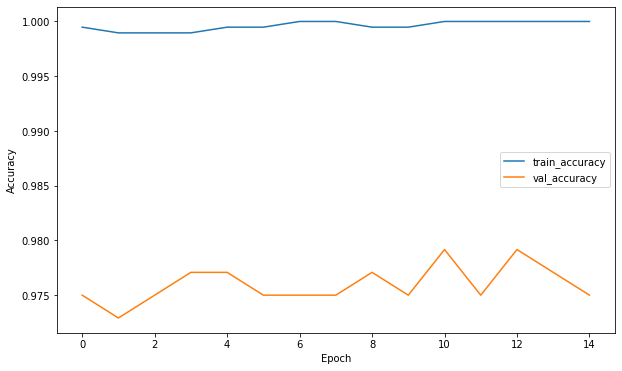

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot the the training loss
plt.plot(result.history["accuracy"], label="train_accuracy")

# Plot the the validation loss
plt.plot(result.history["val_accuracy"], label="val_accuracy")


# Name the x and y axises
plt.ylabel("Accuracy") 
plt.xlabel("Epoch")


# Put legend table
plt.legend()

# Show the plot
plt.show()

In [56]:

import time
t0 = time.time()
degerlendirme = model.evaluate(X_test, y_test)
t1 = time.time()
elapsed = (t1-t0)/600
print(f"loss değeri : {degerlendirme[0]}")
print(f"accuracy değeri : {degerlendirme[1]}\n")

print("bir gözlemin test edilmesi: " + time.strftime("%H:%M:%S:{}".format(str(elapsed % 1)[15:])[:11], time.gmtime(elapsed))+ " milisaniye")


19/19 [==============================] - 1s 17ms/step - loss: 0.1338 - accuracy: 0.9650
loss değeri : 0.1337917000055313
accuracy değeri : 0.9649999737739563

bir gözlemin test edilmesi: 00:00:00:42 milisaniye


In [57]:
prediction1 = model.predict(X_test)
prediction = np.argmax(prediction1,axis=1)


19/19 [==============================] - 1s 21ms/step


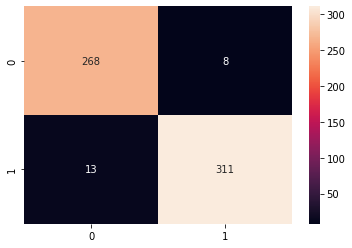

In [58]:
import seaborn as sns
cm = confusion_matrix(y_test, prediction)
f = sns.heatmap(cm, annot=True,fmt='d')

In [59]:
from sklearn.metrics import classification_report

rapor = classification_report(y_test,prediction, labels = [0,1],target_names=["Tümörsüz","Tümörlü"])
print(rapor)

              precision    recall  f1-score   support

    Tümörsüz       0.95      0.97      0.96       276
     Tümörlü       0.97      0.96      0.97       324

    accuracy                           0.96       600
   macro avg       0.96      0.97      0.96       600
weighted avg       0.97      0.96      0.97       600

